In [ ]:
import pandas as pd
import numpy as np
np.random.seed(1337)

**Exploratory Data Ananalysis**


In [ ]:
articles_df= pd.read_csv('/content/content_author_assignment_train.csv')
articles_df.head()

,content,author
0,"Fourth time this season, heavy rains paralysed...",The Quint
1,The BJP has made a significant gain of 11 addi...,PTI
2,Rajya Sabha saw two disruptions on Thursday al...,FP Staff
3,"Senior IPS officer Subodh Jaiswal, who had bee...",The Quint
4,"The government, on 27 February, announced a si...",PTI


In [ ]:
articles_df.shape

(712, 2)

Undersampling the Data to balance the classes




In [ ]:
articles_df = articles_df.drop(articles_df[articles_df.author=='PTI'].sample(n=60).index) #Removing 60 Random rows of author PTI
articles_df = articles_df.drop(articles_df[articles_df.author=='The Quint'].sample(n=20).index) #Removing 20 Random Rows of The Quint

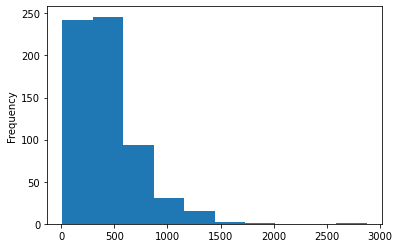

In [ ]:
articles_df.content.apply(lambda x: len(x.split())).plot(kind='hist') #frequency of number of words in per article 

In [ ]:
df = articles_df.copy()

In [ ]:
df['len_txt'] =df.content.apply(lambda x: len(x.split()))
df.describe() #Summary Statistics of the length of articles in the dataset

,len_txt
count,632.000000
mean,440.231013
std,285.816567
min,13.000000
25%,250.000000
50%,351.000000
75%,552.500000
max,2874.000000


In [ ]:
articles_df['author'].value_counts()

PTI                     183
The Quint               163
FP Staff                113
Press Trust of India    106
Scroll Staff             67
Name: author, dtype: int64

**Data Preprocessing**


In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
articles_df['author'] = LE.fit_transform(articles_df['author'])
articles_df.head()

,content,author
0,"Fourth time this season, heavy rains paralysed...",4
1,The BJP has made a significant gain of 11 addi...,1
2,Rajya Sabha saw two disruptions on Thursday al...,0
3,"Senior IPS officer Subodh Jaiswal, who had bee...",4
4,"The government, on 27 February, announced a si...",1


In [ ]:
temp1=list(np.unique(articles_df['author']))
temp2 = list(LE.inverse_transform(temp1))
label_dict = dict(zip(temp2, temp1))

In [ ]:
label_dict

{'FP Staff': 0,
 'PTI': 1,
 'Press Trust of India': 2,
 'Scroll Staff': 3,
 'The Quint': 4}

In [ ]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

In [ ]:
filters = [
           gsp.strip_tags, #Removing unnecessary tags
           gsp.strip_punctuation, #Removing Punctuation
           gsp.strip_multiple_whitespaces, #Removing multiple Whitespaces
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [ ]:
articles_df['content']  = articles_df.content.apply(clean_text)
articles_df.head()

,content,author
0,fourth time this season heavy rains paralysed ...,4
1,the bjp has made a significant gain of 11 addi...,1
2,rajya sabha saw two disruptions on thursday al...,0
3,senior ips officer subodh jaiswal who had been...,4
4,the government on 27 february announced a sign...,1


Splitting the data to train and validation set

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(articles_df, test_size=0.2, random_state=35)
train.head()

,content,author
10,karnataka chief minister siddaramaiah on thurs...,0
426,the rate of population growth among muslims i...,2
212,as many as 1 291 candidates will fight it out ...,0
229,the alliance between the shiv sena and bharati...,0
251,the bharatiya janata party on tuesday accused ...,3


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,content,author
0,karnataka chief minister siddaramaiah on thurs...,0
1,the rate of population growth among muslims i...,2


In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,content,author
0,preparations are underway for the swearing in...,0
1,former uttar pradesh chief minister and samajw...,1


In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (505, 2)
Validation Set Shape : (127, 2)


In [ ]:
DATA_COLUMN = 'content'
LABEL_COLUMN = 'author'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.author)]
label_list

[0, 1, 2, 3, 4]

Breaking the large articles into list of 150 tokens

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else:
    n=1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150+200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,content,author,text_split
0,karnataka chief minister siddaramaiah on thurs...,0,[karnataka chief minister siddaramaiah on thur...
1,the rate of population growth among muslims i...,2,[the rate of population growth among muslims i...
2,as many as 1 291 candidates will fight it out ...,0,[as many as 1 291 candidates will fight it out...
3,the alliance between the shiv sena and bharati...,0,[the alliance between the shiv sena and bharat...
4,the bharatiya janata party on tuesday accused ...,3,[the bharatiya janata party on tuesday accused...


In [ ]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,content,author,text_split
0,preparations are underway for the swearing in...,0,[preparations are underway for the swearing in...
1,former uttar pradesh chief minister and samajw...,1,[former uttar pradesh chief minister and samaj...


In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['author'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(1276, 1276, 1276)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['author'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(317, 317, 317)

Preprocessed Train Dataset

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,content,author
0,karnataka chief minister siddaramaiah on thurs...,0
1,the rate of population growth among muslims in...,2
2,his gun at both the bharatiya janata party bjp...,2
3,the surgical strike in pak occupied kashmir in...,2
4,as many as 1 291 candidates will fight it out ...,0


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,content,author
0,preparations are underway for the swearing in ...,0
1,won two seats in the election but its presiden...,0
2,former uttar pradesh chief minister and samajw...,1
3,prime minister narendra modi on tuesday launch...,1
4,personnel and provided for rs 500 crore in the...,1


#Creating BERT Multi class Classifier for author classification 

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.content.values,
    add_special_tokens = True,
    return_attention_mask=True,
    padding = True,
    max_length = 512,
    return_tensors='pt'
)

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.content.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = True,
    max_length = 512,
    return_tensors = 'pt'
)

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_mask_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.author.values)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_mask_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.author.values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_mask_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_mask_val, labels_val)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels = len(label_list),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size
)

In [ ]:
dataloader_validation = DataLoader(dataset_val,
                         sampler=SequentialSampler(dataset_val),
                         batch_size=batch_size   
)

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps = len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds,labels):
  preds_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
  label_dict_inverse = {v:k for k,v in label_dict.items()}

  preds_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
    accuracy = (len(y_preds[y_preds==label])/len(y_true))*100
    print(accuracy)

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


Model Evaluation

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

  model.train()

  loss_train_total = 0

  progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

  for batch in progress_bar:
    model.zero_grad()
    batch = tuple(b.to(device) for b in batch)

    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
    }
    outputs = model(**inputs)
    loss = outputs[0]
    loss_train_total += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
  
  torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')
  tqdm.write(f'\nEpoch {epoch}')
  loss_train_avg = loss_train_total/len(dataloader_train)
  tqdm.write(f'Training loss: {loss_train_avg}')

  val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score_func(predictions, true_vals)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.3126792140270063
Validation loss: 1.2937667937773578
F1 Score (Weighted): 0.3017498798701696



Epoch 2
Training loss: 1.054167406554793
Validation loss: 1.2054990801327634
F1 Score (Weighted): 0.3800586061131605



Epoch 3
Training loss: 0.834827104189866
Validation loss: 1.041082318520771
F1 Score (Weighted): 0.5826604191231478



Epoch 4
Training loss: 0.6089722934952924
Validation loss: 1.1001486139161125
F1 Score (Weighted): 0.5158555943870325



Epoch 5
Training loss: 0.4724435275551719
Validation loss: 1.1786781948692393
F1 Score (Weighted): 0.5257047243969054



In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_list),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_3.model', map_location=torch.device('cuda')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FP Staff
Accuracy: 36/71

50.70422535211267
Class: PTI
Accuracy: 26/62

41.935483870967744
Class: Press Trust of India
Accuracy: 38/57

66.66666666666666
Class: Scroll Staff
Accuracy: 16/44

36.36363636363637
Class: The Quint
Accuracy: 73/83

87.95180722891565
